## Introduction

**NBA Winners Model: Predicting whether a team will win or lose a given NBA Match**

**Goal:** Build a model that can accurately determine if a given team will win an NBA game using only the known information for both teams competing **up to the start of the game**. To this point, I have been able to build a model that attains a **67.2%** test accuracy for predicting the team's outcome, which is right in line with the best performing models that employ classical ML Models (please refer to the Helpful Resources section). 

**Approach:**
Using the `nba_api`, we contruct a dataframe of game by game data for every matchup from the 2012-13 season to this past season, and focus strictly on regular season games. Each instance (row) contains a team of interest (for convenience call them Team 1), Team 1's counting stats and efficiency, Team 1's opponent (call them Team 2), Team 2's counting stats and efficiency, whether Team 1 was at the home or on the road, and finally if Team 1 won the game (our target variable which is 1 for yes and 0 for no).

Becuase we are largely constrainted by results from past NBA games , I use a rolling average of the team's counting statistics (points, rebounds, assists, etc.) over its previous N games as the respective feature itself, and we employ a similar process to get efficiency (shooting percentage) and winning percentage over the last N games for additional features. N is a parameter I toyed around with. In addition, we also incorporate the volatility of these stats as their own features by looking at the standard deviation of each statistic over the last N games. The only feature not reliant on past games is the `At Home` feature, a boolean that is 1 if Team 1 is playing at home and 0 if they are on the road. 

With the dataset ready, I test a variety of classification models: Logistic Regression, Random Forest, XGBoost and Support Vector Classifier, optimizing for **accuracy**. For each model we calculate the accuracy of the vanilla (fully default parameters) model and then employ hyperparameter tuning using GridSearchCV/RandomSearchCV to obtain better performance. **All results are tabulated at the end**

**Application:** Suppose on a given day during the NBA season you wanted to determine the winners and losers of every game being played that night. Using the methods in this notebook you could build a dataset containing the relevant features for each team that is playing, and then you could run our model to determine the outcomes for each team. As such, this is an incredibly useful for fans of the NBA, sports bettors, someone simply wanting to impress their friends, and so on.

**Motivation:**
* Develop highly accurate and functionally useful model with real-world relevance, specifically to the applications outlined above
* Build on skills relevant to Data Science and Analysis (Data Acquisition, Cleaning, Wrangling, Feature Engineering, EDA, Employing Statistical Methods, Modeling, etc.) and on techniques that are helpful to similar projects
* Work on very interesting and open-ended problem where there is a lot of space to explore ideas and unique approaches
* Learn more about feature importance/optimal feature selection as it relates to the NBA (expand domain knowledge)
* Explore passions in NBA analytically

## Imports

In [135]:
# Data wrangling + manipulation
import numpy as np
import pandas as pd

# EDA + Data Visualization
from collections import Counter
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# NBA API Endpoints and Libraries
from nba_api.stats.endpoints import leaguegamefinder, commonplayerinfo, shotchartdetail, boxscoreadvancedv3, playbyplay, playergamelog, teamgamelog, teamdashlineups, leaguelineupviz
from nba_api.stats.endpoints.shotchartlineupdetail import ConferenceNullable
from nba_api.stats.endpoints.synergyplaytypes import LeagueID
from nba_api.stats.library.parameters import Season, SeasonType, SeasonAll
from nba_api.stats.static import teams, players

# ML modeling
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, cross_val_score, ParameterGrid, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import xgboost as xgb

# Helpful Dictionaries for Team/Player Information
nba_teams = teams.get_teams()
team_info = pd.DataFrame.from_dict(nba_teams)
full_name_dict = team_info.set_index('abbreviation').to_dict()['full_name']
full_name_dict['NOH'] = 'New Orleans Pelicans'

## Create/Load in Main Dataset

This dataset contains data for every NBA game played from the start of the 2012-13 season to the end of the 2023-24 season (including playoffs). Please note that this dataset has additional usage outside the scope of this project, so it will be analyzed and further wrangled later in the "ML Model" section

### Create Dataframe containing relevant game information 

(only run if necessary)

In [136]:
gbg_dfs = []

# Returns the Team ID of Team 2
# Typically stri looks like: [Team 1].[Team 2] or [Team 1]@[Team 2]
# . means Team 1 is at home, @ means Team 1 is on the road, and in
# either case Team 2 is the second entry

def get_opponent(stri):
  if '@' in stri:
    return stri.replace(' ','').split('@')[1]
  else:
    return stri.replace(' ','').split('.')[1]

# Determine whether the team of interest is playing at home (1) or on the road (0)
def get_location(stri):
  if '@' in stri:
    return 0
  else:
    return 1

# Seasons of interest
start_year = 2012
end_year = 2023

# Iterate through each season
for season in [str(x) + '-' + str(x + 1)[2:] for x in range(start_year,end_year+1)]:
    print(season)

    # Get the data for all games in a given season
    games = leaguegamefinder.LeagueGameFinder(
                              league_id_nullable=LeagueID.nba,
                              season_nullable=season)

    # Eastern Conference
    games_dict = games.get_normalized_dict()
    games = games_dict['LeagueGameFinderResults']
    games_df = pd.DataFrame.from_dict(games)

    # Extract Relevant Data & Create Helpful Features
    games_df['GAME_DATE'] = pd.to_datetime(games_df['GAME_DATE'])
    games_df['GAME_TYPE'] = games_df['GAME_ID'].apply(lambda x: x[2])
    games_df['SEASON'] = season
    
    #Filter out preseason, all-star games
    games_df = games_df[(games_df['TEAM_ABBREVIATION'].isin(full_name_dict.keys())) & ((games_df["GAME_TYPE"] != '1') & (games_df['GAME_TYPE'] != '3'))]
    
    # Add helpful features for merging and/or information
    games_df['Opponent'] = games_df['MATCHUP'].apply(lambda x: get_opponent(x))
    games_df['At Home'] = games_df['MATCHUP'].apply(lambda x: get_location(x))
    gbg_dfs.append(games_df)

# Combine all the game-by-game dataframes for each season into one table
game_by_game_df = pd.concat(gbg_dfs)

2012-13
2013-14
2014-15
2015-16
2016-17
2017-18
2018-19
2019-20
2020-21
2021-22
2022-23
2023-24


### Data Wrangling + Feature Engineering

In [137]:
# Create target variable; whether or not the team of interest won
game_by_game_df['Win'] = game_by_game_df['WL'].apply(lambda x: 1 if x == 'W' else 0)

# Columns that either contain relevant features or are crucial for 
# merging dataframes 
key_cols = ['TEAM_ABBREVIATION', 'GAME_ID','GAME_DATE', 'PTS', 'FGM', 'FGA', 'FG_PCT',
       'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB',
       'AST', 'STL', 'BLK', 'TOV', 'PF', 'Win']

# So far we have the statistics for the team of interest, but we also want to 
# store the statistics for the opponent as well; while this may seem like 
# repeating features, this will be helpful for our model
game_by_game_opps_df = game_by_game_df[key_cols]
game_by_game_opps_df = game_by_game_opps_df.add_prefix("Opponent ")
combined_df = game_by_game_df.merge(game_by_game_opps_df,right_on=['Opponent TEAM_ABBREVIATION','Opponent GAME_ID', 'Opponent GAME_DATE'],
                           left_on=['Opponent','GAME_ID','GAME_DATE'])

# Remove uneccessary/non-numeric columns
combined_df = combined_df.drop(['Opponent TEAM_ABBREVIATION', 'Opponent GAME_ID',
       'Opponent GAME_DATE','PLUS_MINUS','TEAM_ID','TEAM_NAME','WL','MIN'],axis=1)

### Save DataFrame for easy reference

In [138]:
combined_df.to_csv('game_by_game.csv', index=False)

## Import DataFrame

Further EDA will be conducted in the ML Model EDA Section

In [139]:
game_by_game_df = pd.read_csv('game_by_game.csv',converters={'GAME_ID': str})

In [140]:
print(game_by_game_df.columns)

# Note that rows with the same GAME_ID are essentially identical;
# this will be resolved in the ML Data Preparation Section
game_by_game_df

Index(['SEASON_ID', 'TEAM_ABBREVIATION', 'GAME_ID', 'GAME_DATE', 'MATCHUP',
       'PTS', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA',
       'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'GAME_TYPE', 'SEASON', 'Opponent', 'At Home', 'Win', 'Opponent PTS',
       'Opponent FGM', 'Opponent FGA', 'Opponent FG_PCT', 'Opponent FG3M',
       'Opponent FG3A', 'Opponent FG3_PCT', 'Opponent FTM', 'Opponent FTA',
       'Opponent FT_PCT', 'Opponent OREB', 'Opponent DREB', 'Opponent AST',
       'Opponent STL', 'Opponent BLK', 'Opponent TOV', 'Opponent PF',
       'Opponent Win'],
      dtype='object')


SEASON_ID TEAM_ABBREVIATION     GAME_ID   GAME_DATE      MATCHUP  PTS  \
0          42012               SAS  0041200407  2013-06-20    SAS @ MIA   88   
1          42012               MIA  0041200407  2013-06-20  MIA vs. SAS   95   
2          42012               SAS  0041200406  2013-06-18    SAS @ MIA  100   
3          42012               MIA  0041200406  2013-06-18  MIA vs. SAS  103   
4          42012               SAS  0041200405  2013-06-16  SAS vs. MIA  114   
...          ...               ...         ...         ...          ...  ...   
30933      22023               DAL  0022300073  2023-10-25    DAL @ SAS  126   
30934      22023               PHX  0022300062  2023-10-24    PHX @ GSW  108   
30935      22023               DEN  0022300061  2023-10-24  DEN vs. LAL  119   
30936      22023               LAL  0022300061  2023-10-24    LAL @ DEN  107   
30937      22023               GSW  0022300062  2023-10-24  GSW vs. PHX  104   

       FGM  FGA  FG_PCT  FG3M  ...  Opponent FTA  Opponent FT_PCT  \
0       31   82   0.378     6  ...            16            0.688   
1       36   82   0.439    12  ...            22            0.909   
2       37   85   0.435     5  ...            21            0.762   
3       38   81   0.469    11  ...            28            0.750   
4       42   70   0.600     9  ...            23            0.826   
...    ...  ...     ...   ...  ...           ...              ...   
30933   47   99   0.475    15  ...            22            0.727   
30934   42   95   0.442    11  ...            28            0.786   
30935   48   91   0.527    14  ...            20            0.750   
30936   41   90   0.456    10  ...            12            0.750   
30937   36  101   0.356    10  ...            17            0.765   

       Opponent OREB  Opponent DREB  Opponent AST  Opponent STL  Opponent BLK  \
0                 11             32            14             8             4   
1                 12             31            13            12             3   
2                 12             30            23            10             6   
3                 12             33            13             8             2   
4                 12             22            25             8             3   
...              ...            ...           ...           ...           ...   
30933              9             36            33             8             5   
30934             18             31            19            11             6   
30935             13             31            23             5             4   
30936              9             33            29             9             6   
30937             17             43            23             5             7   

       Opponent TOV  Opponent PF  Opponent Win  
0                16           19             1  
1                14           19             0  
2                15           26             1  
3                13           21             0  
4                13           24             0  
...             ...          ...           ...  
30933            19           23             0  
30934            11           23             0  
30935            11           18             0  
30936            11           15             1  
30937            19           22             1  

[30938 rows x 46 columns]

## ML Model

### Feature Engineering

Given our DataFrame above, we need to modify it such that our model is functionally viable. After all, the goal is to build a model that can predict the winner of a game without knowing what occurs in the game itself. Instead I opted to change each team statistic (Points, Assists, Steals, etc.) to the average of that statistic over the last N games, where N is a parameter we play around with.

In this section we update our features to only contain info that is available to us before the game starts, averaging counting stats, win percentage, efficiency stats, etc. over the last N games

In [141]:
# Last N Games
window_size = 15

# But for wins, we keep this at win percentage over last 10 games for now
win_window_size = 10
test_df = game_by_game_df.sort_values(by=['TEAM_ABBREVIATION','GAME_DATE']).reset_index(drop=True)

# Calculate win percentage up to upcoming game
test_df['Cum Wins'] = test_df.groupby(['TEAM_ABBREVIATION','SEASON']).apply(lambda x:
    x.Win.cumsum().shift(1)).reset_index(drop=True)
test_df = test_df.fillna(0)
test_df['Games so Far'] = test_df.groupby(['TEAM_ABBREVIATION','SEASON']).cumcount()
test_df['Win Percentage'] = test_df['Cum Wins'] / test_df['Games so Far']

# Calculate rolling win percentage over last 10 games
test_df[f'L{win_window_size} Win Percentage'] = test_df[['TEAM_ABBREVIATION','SEASON','Win']]\
    .groupby(['TEAM_ABBREVIATION','SEASON'])['Win'].shift(1).rolling(window=win_window_size).sum().reset_index(drop=True) / win_window_size

# For All other Aggregated Features
averaged_features = ['BLK','AST','STL','TOV','PF','OREB','DREB','PTS']
for feature in averaged_features:
    test_df[f'L{str(window_size)} {feature}S Avg'] = test_df.groupby(['TEAM_ABBREVIATION','SEASON'])[feature].shift(1).rolling(window=window_size).mean().reset_index(drop=True) 
    test_df[f'L{str(window_size)} {feature}S Avg Against'] = test_df.groupby(['TEAM_ABBREVIATION','SEASON'])[f'Opponent {feature}'].shift(1).rolling(window=window_size).mean().reset_index(drop=True) 
    test_df[f'L{str(window_size)} {feature}S Variability'] = test_df.groupby(['TEAM_ABBREVIATION','SEASON'])[feature].shift(1).rolling(window=window_size).std().reset_index(drop=True) 
    test_df[f'L{str(window_size)} {feature}S Variability Against'] = test_df.groupby(['TEAM_ABBREVIATION','SEASON'])[f'Opponent {feature}'].shift(1).rolling(window=window_size).std().reset_index(drop=True) 
    if feature not in ['FTA','FGA','PTS']:
        test_df = test_df.drop([feature, f'Opponent {feature}'],axis=1)

# True Shooting Percentages Features 

# Step 1: Get total sum of attempts and makes
pct_features = ['FTA','FGA','PTS']

for feature in pct_features:
    test_df[f'L{str(window_size)} {feature}'] = test_df.groupby(['TEAM_ABBREVIATION','SEASON'])[feature].shift(1).rolling(window=window_size).sum().reset_index(drop=True) 
    test_df[f'Allowed L{str(window_size)} {feature}'] = test_df.groupby(['TEAM_ABBREVIATION','SEASON'])[f'Opponent {feature}'].shift(1).rolling(window=window_size).sum().reset_index(drop=True) 
    test_df = test_df.drop([feature, f'Opponent {feature}'],axis=1)


# Step 2: Calculate Percentages
test_df[f'L{window_size} True Shooting Pct'] = 100 * test_df[f'L{str(window_size)} PTS'] / (2 * test_df[f'L{str(window_size)} FGA'] + 0.44 * test_df[f'L{str(window_size)} FTA'])
test_df[f'L{window_size} True Shooting Pct Allowed'] = 100 * test_df[f'Allowed L{str(window_size)} PTS'] / (2 * test_df[f'Allowed L{str(window_size)} FGA'] + 0.44 * test_df[f'Allowed L{str(window_size)} FTA'])

# Drop unnecessary columns
drop_cols = ['SEASON_ID','GAME_DATE','MATCHUP','FG_PCT','FG3_PCT','FT_PCT','REB',
'GAME_TYPE','SEASON', 'Opponent FG_PCT','Opponent FG3_PCT','Opponent FT_PCT', 'Cum Wins', 'Games so Far',
'Opponent Win','FGM','FG3M','FTM','Opponent FGM','Opponent FG3M','Opponent FTM',
f'L{window_size} FTA', f'Allowed L{window_size} FTA', f'L{window_size} FGA', f'Allowed L{window_size} FGA', 
f'L{window_size} PTS', f'Allowed L{window_size} PTS', 'FG3A','Opponent FG3A']

# Show data
test_df = test_df.drop(drop_cols, axis = 1)
test_df.head(20).tail(10)

C:\Users\ynakadi\AppData\Local\Temp\ipykernel_2464\3768585347.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_df['Cum Wins'] = test_df.groupby(['TEAM_ABBREVIATION','SEASON']).apply(lambda x:


TEAM_ABBREVIATION     GAME_ID Opponent  At Home  Win  Win Percentage  \
10               ATL  0021200171      CHA        0    1        0.600000   
11               ATL  0021200185      LAC        1    1        0.636364   
12               ATL  0021200212      CHA        1    1        0.666667   
13               ATL  0021200227      CLE        1    0        0.692308   
14               ATL  0021200260      DEN        1    1        0.642857   
15               ATL  0021200273      WAS        1    1        0.666667   
16               ATL  0021200289      MEM        0    1        0.687500   
17               ATL  0021200300      MIA        0    0        0.705882   
18               ATL  0021200310      ORL        0    1        0.666667   
19               ATL  0021200322      CHA        1    1        0.684211   

    L10 Win Percentage  L15 BLKS Avg  L15 BLKS Avg Against  \
10                 0.6           NaN                   NaN   
11                 0.7           NaN                   NaN   
12                 0.7           NaN                   NaN   
13                 0.7           NaN                   NaN   
14                 0.7           NaN                   NaN   
15                 0.8      5.333333              4.666667   
16                 0.8      5.133333              4.800000   
17                 0.9      5.266667              4.533333   
18                 0.8      5.133333              4.266667   
19                 0.8      5.200000              4.333333   

    L15 BLKS Variability  ...  L15 DREBS Avg  L15 DREBS Avg Against  \
10                   NaN  ...            NaN                    NaN   
11                   NaN  ...            NaN                    NaN   
12                   NaN  ...            NaN                    NaN   
13                   NaN  ...            NaN                    NaN   
14                   NaN  ...            NaN                    NaN   
15              3.415650  ...      29.600000              32.200000   
16              3.583029  ...      29.800000              31.533333   
17              3.453087  ...      30.066667              31.466667   
18              3.583029  ...      29.400000              31.466667   
19              3.589668  ...      29.800000              31.533333   

    L15 DREBS Variability  L15 DREBS Variability Against  L15 PTSS Avg  \
10                    NaN                            NaN           NaN   
11                    NaN                            NaN           NaN   
12                    NaN                            NaN           NaN   
13                    NaN                            NaN           NaN   
14                    NaN                            NaN           NaN   
15               4.792852                       4.616740     97.000000   
16               4.828487                       4.897035     97.133333   
17               4.712698                       4.926121     96.400000   
18               4.822566                       4.926121     96.600000   
19               5.031330                       4.882427     96.400000   

    L15 PTSS Avg Against  L15 PTSS Variability  L15 PTSS Variability Against  \
10                   NaN                   NaN                           NaN   
11                   NaN                   NaN                           NaN   
12                   NaN                   NaN                           NaN   
13                   NaN                   NaN                           NaN   
14                   NaN                   NaN                           NaN   
15             94.200000             10.743769                      9.900938   
16             93.266667             10.822375                      9.027471   
17             92.466667             10.695794                      9.387428   
18             93.466667             10.574903                      9.448104   
19             92.466667             10.755729                     10.048928   

    L15 True Sho

In [142]:
# Examine features for a given team
test_df.columns

Index(['TEAM_ABBREVIATION', 'GAME_ID', 'Opponent', 'At Home', 'Win',
       'Win Percentage', 'L10 Win Percentage', 'L15 BLKS Avg',
       'L15 BLKS Avg Against', 'L15 BLKS Variability',
       'L15 BLKS Variability Against', 'L15 ASTS Avg', 'L15 ASTS Avg Against',
       'L15 ASTS Variability', 'L15 ASTS Variability Against', 'L15 STLS Avg',
       'L15 STLS Avg Against', 'L15 STLS Variability',
       'L15 STLS Variability Against', 'L15 TOVS Avg', 'L15 TOVS Avg Against',
       'L15 TOVS Variability', 'L15 TOVS Variability Against', 'L15 PFS Avg',
       'L15 PFS Avg Against', 'L15 PFS Variability',
       'L15 PFS Variability Against', 'L15 OREBS Avg', 'L15 OREBS Avg Against',
       'L15 OREBS Variability', 'L15 OREBS Variability Against',
       'L15 DREBS Avg', 'L15 DREBS Avg Against', 'L15 DREBS Variability',
       'L15 DREBS Variability Against', 'L15 PTSS Avg', 'L15 PTSS Avg Against',
       'L15 PTSS Variability', 'L15 PTSS Variability Against',
       'L15 True Shooting Pc

### Add Opponent Features to Every Entry

So far we have the key features for Team 1 in every row, but we want to include the same features for the opponent; we do this by creating a copy of the DataFrame and merging it with the dataset where Team 2's TEAMID and GAMEID of one table equals Team 1's TEAMID and GAMEID of the other

In [143]:
test_df_opp = test_df
test_df_opp = test_df_opp.add_prefix("Opponent ")
full_df = test_df.merge(test_df_opp,right_on=['Opponent TEAM_ABBREVIATION','Opponent GAME_ID'],
                           left_on=['Opponent','GAME_ID'])
full_df = full_df.drop(['Opponent GAME_ID', 'Opponent Opponent', 'Opponent TEAM_ABBREVIATION',
'Opponent At Home', 'Opponent Win'],axis=1)
full_df = full_df.dropna().reset_index(drop=True)
info_df = full_df[['TEAM_ABBREVIATION','GAME_ID','Opponent']]

# Here we drop rows with a repeated GAME_ID to avoid double counting entries
full_df = full_df.loc[list(full_df['GAME_ID'].drop_duplicates().index)]
full_df = full_df.drop(['TEAM_ABBREVIATION','GAME_ID','Opponent'],axis=1)
full_df.columns

Index(['At Home', 'Win', 'Win Percentage', 'L10 Win Percentage',
       'L15 BLKS Avg', 'L15 BLKS Avg Against', 'L15 BLKS Variability',
       'L15 BLKS Variability Against', 'L15 ASTS Avg', 'L15 ASTS Avg Against',
       'L15 ASTS Variability', 'L15 ASTS Variability Against', 'L15 STLS Avg',
       'L15 STLS Avg Against', 'L15 STLS Variability',
       'L15 STLS Variability Against', 'L15 TOVS Avg', 'L15 TOVS Avg Against',
       'L15 TOVS Variability', 'L15 TOVS Variability Against', 'L15 PFS Avg',
       'L15 PFS Avg Against', 'L15 PFS Variability',
       'L15 PFS Variability Against', 'L15 OREBS Avg', 'L15 OREBS Avg Against',
       'L15 OREBS Variability', 'L15 OREBS Variability Against',
       'L15 DREBS Avg', 'L15 DREBS Avg Against', 'L15 DREBS Variability',
       'L15 DREBS Variability Against', 'L15 PTSS Avg', 'L15 PTSS Avg Against',
       'L15 PTSS Variability', 'L15 PTSS Variability Against',
       'L15 True Shooting Pct', 'L15 True Shooting Pct Allowed',
       'Oppone

### Prepare Data For Modeling

With the dataset now complete, we split our table into our feature dataset (X) and our target variable dataset (Y). We opt to use an 80/20 train/test split.

In [144]:
X = full_df[[x for x in full_df.columns if x != 'Win']]
Y = full_df['Win']

# For consistency across models
random_seed = 42

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=random_seed)

# Optional: When running entire coding section, you might not want to 
# run hyperparameter tuning as it is time consuming
DO_SEARCH = False
X.columns

Index(['At Home', 'Win Percentage', 'L10 Win Percentage', 'L15 BLKS Avg',
       'L15 BLKS Avg Against', 'L15 BLKS Variability',
       'L15 BLKS Variability Against', 'L15 ASTS Avg', 'L15 ASTS Avg Against',
       'L15 ASTS Variability', 'L15 ASTS Variability Against', 'L15 STLS Avg',
       'L15 STLS Avg Against', 'L15 STLS Variability',
       'L15 STLS Variability Against', 'L15 TOVS Avg', 'L15 TOVS Avg Against',
       'L15 TOVS Variability', 'L15 TOVS Variability Against', 'L15 PFS Avg',
       'L15 PFS Avg Against', 'L15 PFS Variability',
       'L15 PFS Variability Against', 'L15 OREBS Avg', 'L15 OREBS Avg Against',
       'L15 OREBS Variability', 'L15 OREBS Variability Against',
       'L15 DREBS Avg', 'L15 DREBS Avg Against', 'L15 DREBS Variability',
       'L15 DREBS Variability Against', 'L15 PTSS Avg', 'L15 PTSS Avg Against',
       'L15 PTSS Variability', 'L15 PTSS Variability Against',
       'L15 True Shooting Pct', 'L15 True Shooting Pct Allowed',
       'Opponent Win 

In [145]:

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

### EDA

Conduct exploratory data analysis (EDA) for our datasets, in particular our feature dataset X

#### Check Target Variable Matrix

Ensure that there is a rougly equal sample of wins (1) and losses (0)

In [146]:
Counter(Y)

Counter({1: 6444, 0: 6232})

In [147]:
X.describe(include='all')

At Home  Win Percentage  L10 Win Percentage  L15 BLKS Avg  \
count  12676.000000    12676.000000        12676.000000  12676.000000   
mean       0.500868        0.515154            0.513963      4.815268   
std        0.500019        0.157109            0.205135      0.990623   
min        0.000000        0.000000            0.000000      1.800000   
25%        0.000000        0.411765            0.400000      4.133333   
50%        1.000000        0.524390            0.500000      4.733333   
75%        1.000000        0.625000            0.700000      5.400000   
max        1.000000        1.000000            1.000000      9.266667   

       L15 BLKS Avg Against  L15 BLKS Variability  \
count          12676.000000          12676.000000   
mean               4.841059              2.343632   
std                0.947560              0.532923   
min                2.000000              0.736788   
25%                4.200000              1.980861   
50%                4.800000              2.294922   
75%                5.466667              2.669047   
max                9.000000              4.825527   

       L15 BLKS Variability Against  L15 ASTS Avg  L15 ASTS Avg Against  \
count                  12676.000000  12676.000000          12676.000000   
mean                       2.352116     23.874393             23.728973   
std                        0.528432      2.686765              2.336892   
min                        0.798809     16.133333             14.466667   
25%                        1.980861     21.933333             22.133333   
50%                        2.319688     23.600000             23.800000   
75%                        2.672612     25.666667             25.333333   
max                        4.495500     33.733333             31.866667   

       L15 ASTS Variability  ...  Opponent L15 DREBS Avg  \
count          12676.000000  ...            12676.000000   
mean               4.581052  ...               33.251956   
std                0.934870  ...                2.316856   
min                1.934647  ...               26.466667   
25%                3.936399  ...               31.733333   
50%                4.558613  ...               33.200000   
75%                5.179860  ...               34.733333   
max                8.760300  ...               45.266667   

       Opponent L15 DREBS Avg Against  Opponent L15 DREBS Variability  \
count                    12676.000000                    12676.000000   
mean                        33.107647                        4.996967   
std                          2.266077                        0.988913   
min                         25.666667                        1.907379   
25%                         31.533333                        4.303930   
50%                         33.066667                        4.934813   
75%                         34.666667                        5.612698   
max                         42.533333                        8.997354   

       Opponent L15 DREBS Variability Against  Opponent L15 PTSS Avg  \
count                            12676.000000           12676.000000   
mean                                 5.035125             107.342090   
std                                  0.975113               7.602441   
min                                  2.236068              86.400000   
25%                                  4.340287             101.800000   
50%                                  4.998095             107.600000   
75%                                  5.666947             113.133333   
max                                  8.967136             130.333333   

       Opponent L15 PTSS Avg Against  Opponent L15 PTSS Variability  \
count                   12676.000000                   12676.000000   
mean                      107.069486                      11.087050   
std                         7.543367                       2.198410   
min                        82.466667                       3.913347 

#### Correlation Heatmap for Features

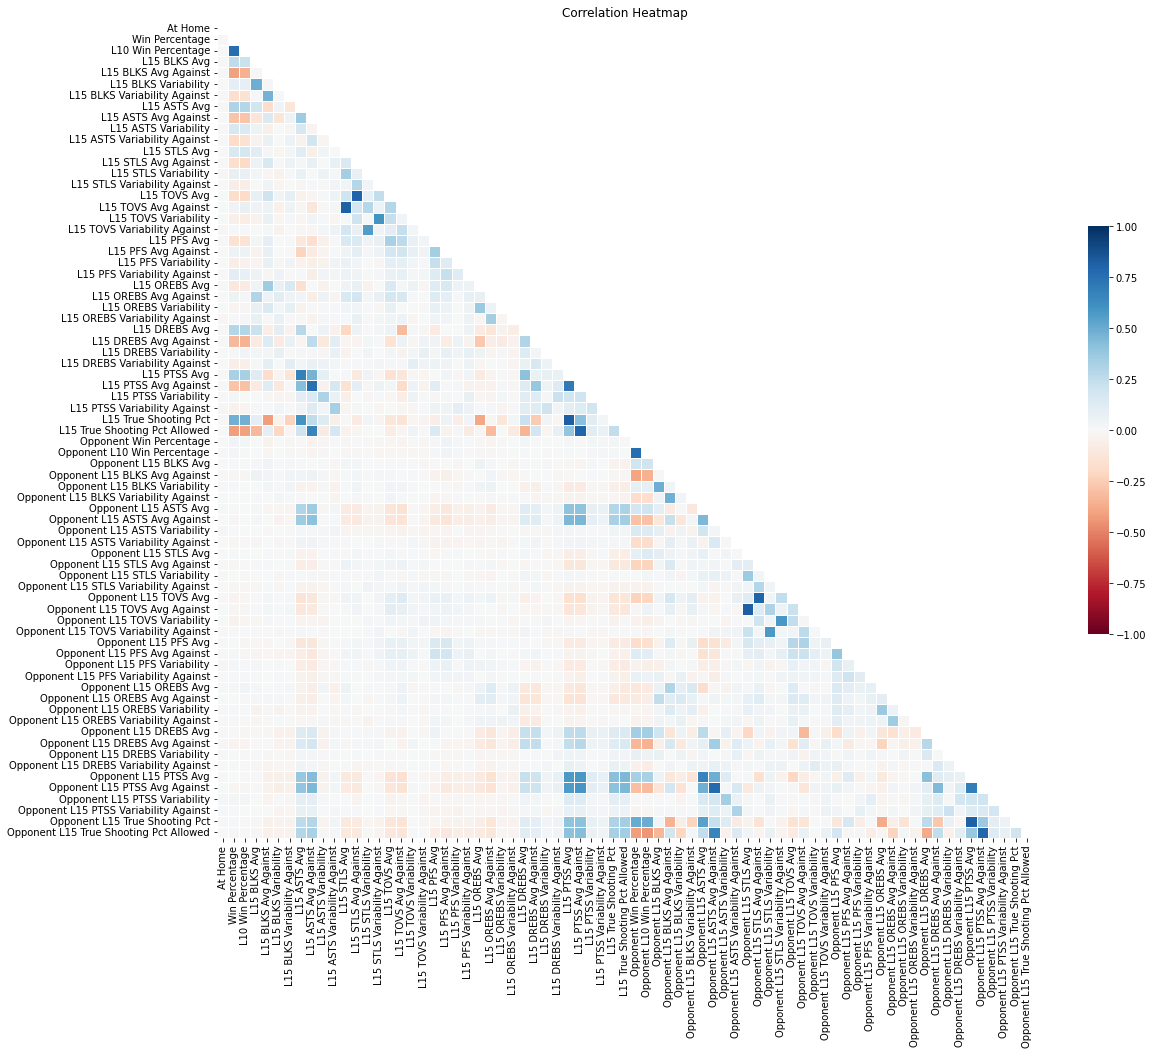

In [148]:
corr = X_train.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corr, mask=mask, cmap='RdBu', vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Correlation Heatmap")
plt.show() 

Some observations from the table above include: 
* Strong correlation between efficiency (True Shooting Percentage) and scoring (Avg Points Scored Over Last N Games), which is expected
* Strong correlation between points scored and assists over last n games, which makes sense
* Strong correlation between Steals and Turnovers Forced

#### Pairplot Graph

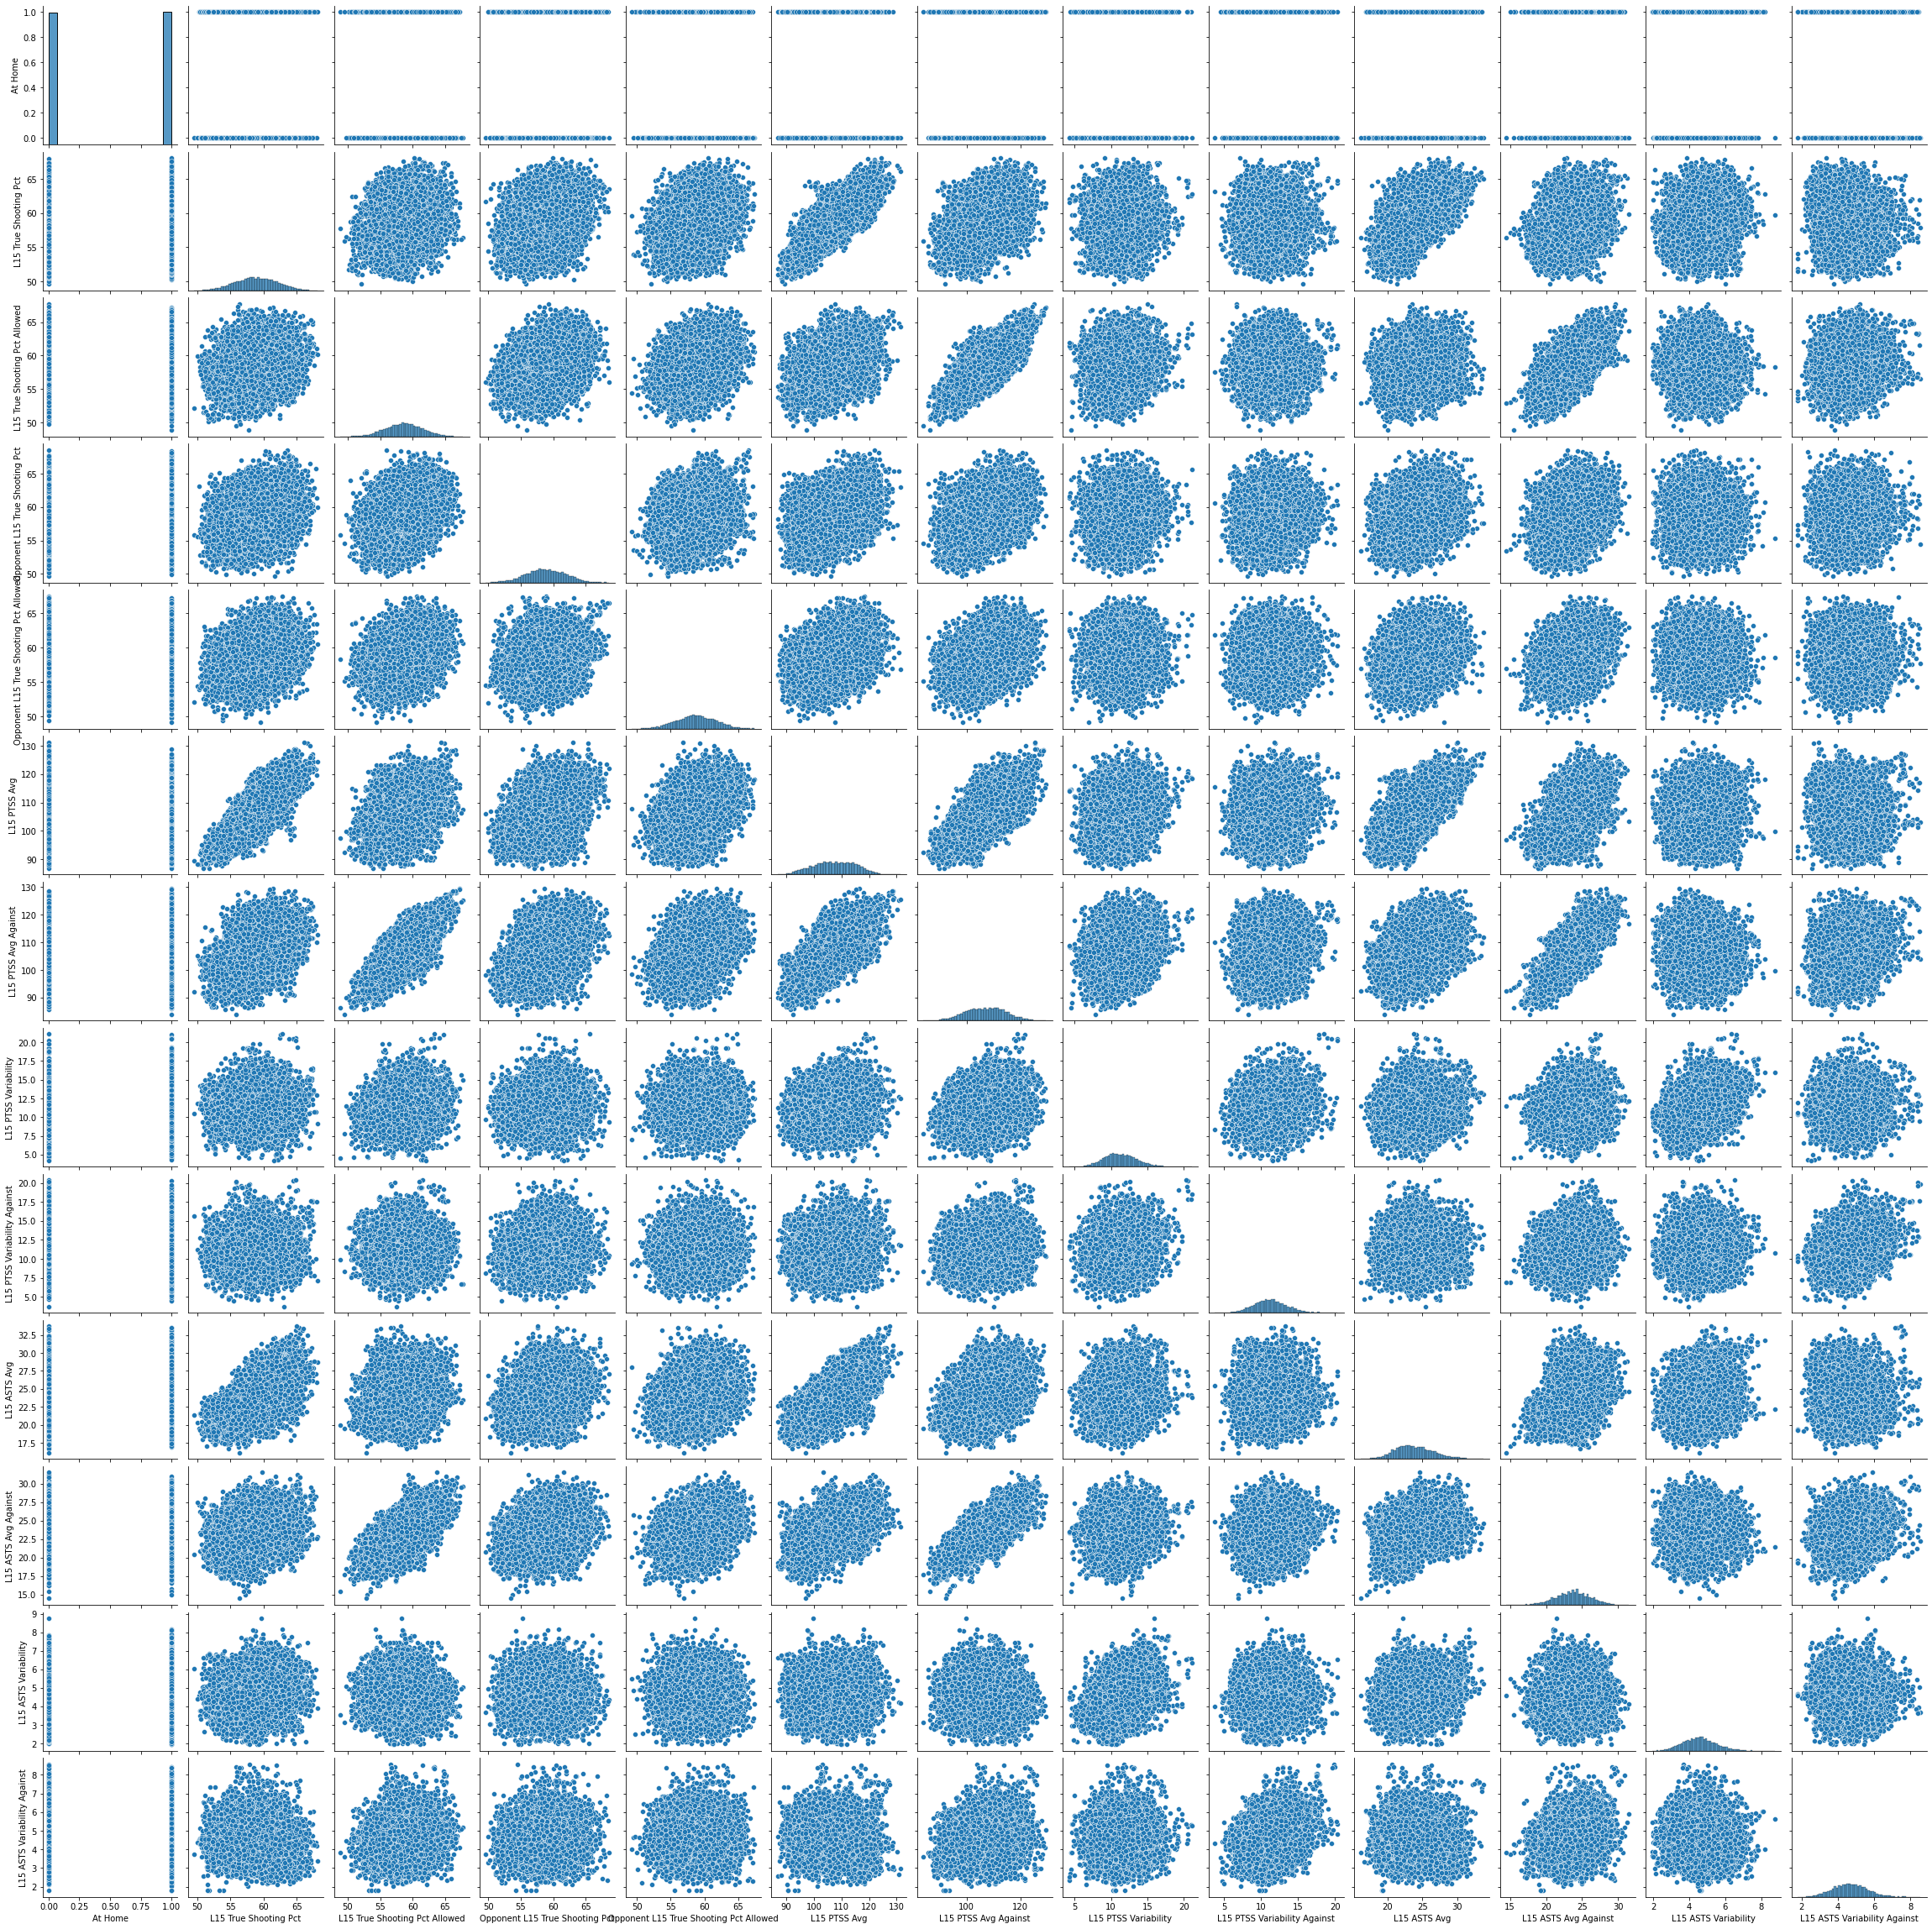

In [149]:
# To avoid crashing kernel, focus on subset of features inspired by
# observations seen above (Points, Assists, True Shooting Pct)
pairplot_features = ['At Home', f'L{window_size} True Shooting Pct', f'L{window_size} True Shooting Pct Allowed',
                     f'Opponent L{window_size} True Shooting Pct', f'Opponent L{window_size} True Shooting Pct Allowed',
                     f'L{window_size} PTSS Avg', f'L{window_size} PTSS Avg Against',
    f'L{window_size} PTSS Variability', f'L{window_size} PTSS Variability Against',
    f'L{window_size} ASTS Avg', f'L{window_size} ASTS Avg Against',
    f'L{window_size} ASTS Variability', f'L{window_size} ASTS Variability Against']
sns.pairplot(X_train[pairplot_features])

#### PCA

Principal Component Analysis is a statistical technique that takes a high-dimensional dataset (lots of features) and projects into a lower dimensional space in a way that preserves information (maximizes variance). We replace our features with principal components that encode information about the features (as each PC is a linear combination of the features), in particular which ones are the most important. Given that we have over 70 features, dimensionality reduction can assist us in understanding which features are the most important and help make our model less redundant.

Note that PCA is NOT scale invariant, so we must standardize our feature dataset (X) for this model. Here we will be using X_train

##### Standardize Data + Plot Cumulative Importance of PCs

Here we start by standardizing the data, and then conduct PCA
on this new dataset. We then use `explained_variance_ratio` to 
find the minimum number of components needed to reach a certain
threshold of explained variance (in this case 80%), and plot these
findings

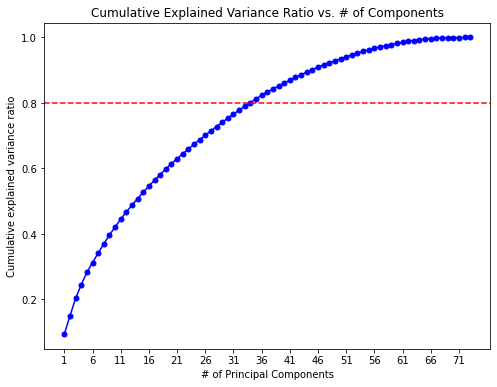

In [150]:
# Standardize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Conduct PCA on standardized data
pca = PCA()
rand = pca.fit_transform(X_train_scaled)

# Get the relative importance of each eigenvector and cumulatively sum
explained_variance_ratios = pca.explained_variance_ratio_
cum_evr = np.cumsum(explained_variance_ratios)

# How many PCs we need to acquire 80% of the variance
n_components = np.argmax(cum_evr >= 0.8) + 1

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(range(1, len(cum_evr) + 1), cum_evr, marker='o', markersize=5, color='blue')
ax.axhline(y=0.8, color='red', linestyle='--')
ax.set_xticks([x for x in range(1,len(X.columns),5)])
ax.set_xlabel('# of Principal Components')
ax.set_ylabel('Cumulative explained variance ratio')
ax.set_title('Cumulative Explained Variance Ratio vs. # of Components')
plt.show()

##### Determine Feature Importance

For each principal component calculated above, determine the n most important features, as determined by explained variance. Recall PC1 is the most important eigenvector. Helpful illustration of the procedure found [here](https://stackoverflow.com/questions/50796024/feature-variable-importance-after-a-pca-analysis)

Note that we will be referencing the variables here in Model 2: Logistic Regression with PCA

In [151]:
# Conduct PCA on with the minimum number of components needed to reach 80%
pca_final = PCA(n_components)
X_train_pca = pca_final.fit_transform(X_train_scaled)
X_test_pca = pca_final.transform(X_test_scaled)

# Determine how many important features per PC we want to observe, and note
# that the number must be negative 
top_n_features = -5

most_important_features = [np.argpartition(np.abs(pca_final.components_[i]), top_n_features)[top_n_features:]
                           for i in range(n_components)]
initial_feature_names = X_train.columns

# Using those indices, find the relevant features
most_important_names = [list(initial_feature_names[most_important_features[i]]) for i in range(n_components)]

# Create a list of identical length that will rank the features in order of most explained variance
pc_list = ["PC"+str(x) for x in range(1, n_components+1)]

# Combine the two previous columns under one dataframe
df = pd.DataFrame()
df['Principal Component'] = pc_list
df['5 Most Important Statistics (in order)'] = most_important_names
with pd.option_context('display.max_colwidth', None):
  display(df)

Principal Component  \
0                  PC1   
1                  PC2   
2                  PC3   
3                  PC4   
4                  PC5   
5                  PC6   
6                  PC7   
7                  PC8   
8                  PC9   
9                 PC10   
10                PC11   
11                PC12   
12                PC13   
13                PC14   
14                PC15   
15                PC16   
16                PC17   
17                PC18   
18                PC19   
19                PC20   
20                PC21   
21                PC22   
22                PC23   
23                PC24   
24                PC25   
25                PC26   
26                PC27   
27                PC28   
28                PC29   
29                PC30   
30                PC31   
31                PC32   
32                PC33   
33                PC34   

                                                                                                                                          5 Most Important Statistics (in order)  
0                                                      [Opponent L15 ASTS Avg Against, Opponent L15 PTSS Avg Against, L15 PTSS Avg, L15 PTSS Avg Against, Opponent L15 PTSS Avg]  
1                  [Opponent L15 True Shooting Pct, Opponent L15 True Shooting Pct Allowed, Opponent L10 Win Percentage, Opponent Win Percentage, Opponent L15 BLKS Avg Against]  
2                                                               [L15 True Shooting Pct Allowed, L15 True Shooting Pct, L10 Win Percentage, L15 BLKS Avg Against, Win Percentage]  
3                                                                                          [L15 PFS Avg, L15 STLS Avg Against, L15 STLS Avg, L15 TOVS Avg Against, L15 TOVS Avg]  
4                            [Opponent L15 TOVS Avg, Opponent L15 TOVS Variability Against, Opponent L15 STLS Variability, Opponent L15 TOVS Avg Against, Opponent L15 STLS Avg]  
5                            [Opponent L15 STLS Variability Against, Opponent L15 TOVS Avg Against, Opponent L15 STLS Avg, Opponent L15 TOVS Avg, Opponent L15 STLS Avg Against]  
6                                                                                [L15 BLKS Variability, L15 STLS Variability, L15 DREBS Avg, L15 TOVS Avg Against, L15 STLS Avg]  
7                                                 [Opponent L15 DREBS Avg Against, Opponent L15 OREBS Avg, L15 DREBS Avg Against, L15 DREBS Avg, Opponent L15 OREBS Avg Against]  
8                                                                  [L15 PFS Avg, Opponent L15 PFS Avg, Opponent L15 PFS Avg Against, Opponent L15 BLKS Avg, L15 PFS Avg Against]  
9                                                                 [L15 BLKS Avg Against, L15 STLS Variability Against, L15 BLKS Avg, L15 TOVS Variability, L15 BLKS Variability]  
10                                               [L15 STLS Avg Against, L15 DREBS Avg Against, L15 PTSS Variability Against, L15 TOVS Variability, L15 STLS Variability Against]  
11           [Opponent L15 ASTS Variability Against, L15 PTSS Variability, Opponent L15 DREBS Avg Against, Opponent L15 PTSS Variability Against, Opponent L15 PTSS Variability]  
12                                                                    [L15 BLKS Avg, L15 OREBS Variability Against, L15 DREBS Avg Against, L15 OREBS Avg Against, L15 OREBS Avg]  
13                                      [L15 ASTS Variability Against, L15 STLS Variability, L15 OREBS Avg Against, L15 OREBS Variability Against, L15 TOVS Variability Against]  
14                                       [L15 PTSS Variability Against, L15 TOVS Variability Against, L15 ASTS Variability, L15 PTSS Variability, L15 DREBS Variability Against]  
15       [Opponent L15 PTSS Variability Against, Opponent L15 OREBS Avg, Opponent L15 OREBS Variability Against, Opponent L15 OREBS Variability, Opponent L15 OREBS Avg Against]  
16                                      [L15 PTSS

### Model 1: Logistic Regression

We are working on a classification problem, and so it makes sense to use a Logistic Regression model for our baseline; here we start with a vanilla model and then in a subsequent section use GridSearch to optimally tune our hyperparameters.

We use accuracy score to gauge how effective our model is, but also explore precision and recall.

#### Vanilla Logistic Regression (Baseline)

In [152]:
log_reg1 = LogisticRegression(solver='saga',penalty='none',random_state=random_seed)
log_reg1.fit(X_train, y_train)
vanila_log_reg_preds = log_reg1.predict(X_test)
vanila_log_reg_acc = round(100 * log_reg1.score(X_test, y_test),2)

C:\Users\ynakadi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Model's test accuracy is 64.0%
 the precision is 63.77% 
 the recall is 66.41% 
 the f-score is 65.06%


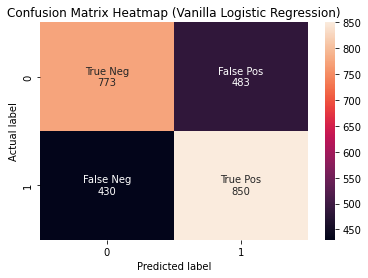

In [153]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,vanila_log_reg_preds)
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)

test_accuracy = (cm[0][0] + cm[1][1]) / (cm[0][0] + cm[1][1] + cm[0][1] + cm[1][0])
precision = cm[1][1] / (cm[1][1]+cm[0][1])
recall = cm[1][1] / (cm[1][1]+cm[1][0])

f_measure = (2 * precision * recall) / (precision + recall)

final_string = "Model's test accuracy is {}%\n the precision is {}% \n the recall is {}% \n the f-score is {}%"\
.format(round(100*test_accuracy,2), round(100*precision,2), round(100*recall,2), round(100*f_measure,2))
print(final_string)
sns.heatmap(cm, annot=labels,fmt='')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix Heatmap (Vanilla Logistic Regression)")
plt.show()


#### Tuned Logistic Regression

Experiment with Regularization Parameters

In [154]:
# Regularization with help of GridSearch
# "l1_ratio":[0.1 * x for x in range(11)]
best_score = 0
params = {'C':[1e-2, 1e-1, 1, 10, 100, 1000]}
log_reg = LogisticRegression(solver='saga',penalty='elasticnet',max_iter=1000,l1_ratio=1)

if DO_SEARCH:
    for param_set in ParameterGrid(params):
        log_reg.set_params(**param_set)
        log_reg.fit(X_train,y_train)
        # save best grid set
        score = log_reg.score(X_test,y_test )
        if score > best_score:
            best_score = score
            best_grid = param_set


# grid_search = RandomizedSearchCV(log_reg, param_distributions = params, n_iter = 30, cv = 5, scoring = 'accuracy', random_state = random_seed)


In [155]:
# Use best performing model

log_reg = LogisticRegression(C = 1, solver='saga',penalty='elasticnet',l1_ratio=1,max_iter=1000,
                             random_state=random_seed)
log_reg.fit(X_train, y_train)
tuned_log_reg_preds = log_reg.predict(X_test)
tuned_log_reg_acc = round(100*log_reg.score(X_test, y_test),2)

C:\Users\ynakadi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Model's test accuracy is 65.14%
 the precision is 65.05% 
 the recall is 66.88% 
 the f-score is 65.95%


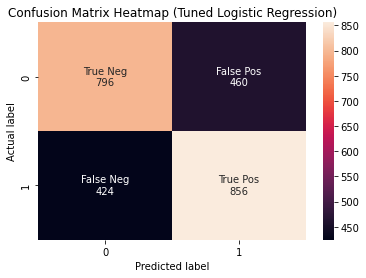

In [156]:
cm = confusion_matrix(y_test,tuned_log_reg_preds)
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)

test_accuracy = (cm[0][0] + cm[1][1]) / (cm[0][0] + cm[1][1] + cm[0][1] + cm[1][0])
precision = cm[1][1] / (cm[1][1]+cm[0][1])
recall = cm[1][1] / (cm[1][1]+cm[1][0])

f_measure = (2 * precision * recall) / (precision + recall)

final_string = "Model's test accuracy is {}%\n the precision is {}% \n the recall is {}% \n the f-score is {}%"\
.format(round(100*test_accuracy,2), round(100*precision,2), round(100*recall,2), round(100*f_measure,2))
print(final_string)
sns.heatmap(cm, annot=labels,fmt='')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix Heatmap (Tuned Logistic Regression)")
plt.show()

### Model 2: Logistic Regression with PCA

Recall the work we did with PCA in the EDA section; here we will run our best-performing Logistic Regression model on our scaled datasets

In [157]:
# Use best-performing model up to this point
log_reg_pca = LogisticRegression(C = 1, solver='saga',penalty='elasticnet',l1_ratio=1,random_state=random_seed)
log_reg_pca.fit(X_train_pca, y_train)

# Make predictions on the test set
pca_log_reg_preds = log_reg_pca.predict(X_test_pca)

# Calculate accuracy of the model on the test set
pca_log_reg_acc = round(100*log_reg_pca.score(X_test_pca, y_test),2)

Model's test accuracy is 65.42%
 the precision is 65.46% 
 the recall is 66.64% 
 the f-score is 66.05%


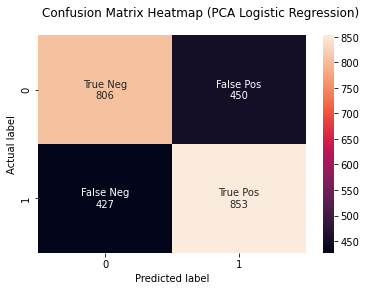

In [158]:
cm = confusion_matrix(y_test,pca_log_reg_preds)
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)

test_accuracy = (cm[0][0] + cm[1][1]) / (cm[0][0] + cm[1][1] + cm[0][1] + cm[1][0])
precision = cm[1][1] / (cm[1][1]+cm[0][1])
recall = cm[1][1] / (cm[1][1]+cm[1][0])

f_measure = (2 * precision * recall) / (precision + recall)

final_string = "Model's test accuracy is {}%\n the precision is {}% \n the recall is {}% \n the f-score is {}%"\
.format(round(100*test_accuracy,2), round(100*precision,2), round(100*recall,2), round(100*f_measure,2))
print(final_string)
sns.heatmap(cm, annot=labels,fmt='')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.suptitle("Confusion Matrix Heatmap (PCA Logistic Regression)")
plt.show()

### Model 3: Random Forest

Now we start to look at decision tree classifiers. We start by exploring one of the most popular Boostrap Aggregation models, Random Forest Models

#### Vanilla Random Forest

In [159]:
# Vanilla RF model
rf = RandomForestClassifier(random_state = random_seed)
rf = rf.fit(X_train,y_train)
vanilla_rf_preds = rf.predict(X_test)
vanilla_rf_acc = round(100*rf.score(X_test,y_test),2)

Model's test accuracy is 63.92%
 the precision is 63.9% 
 the recall is 65.55% 
 the f-score is 64.71%


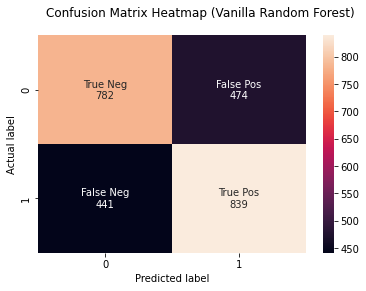

In [160]:
cm = confusion_matrix(y_test,vanilla_rf_preds)
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)

test_accuracy = (cm[0][0] + cm[1][1]) / (cm[0][0] + cm[1][1] + cm[0][1] + cm[1][0])
precision = cm[1][1] / (cm[1][1]+cm[0][1])
recall = cm[1][1] / (cm[1][1]+cm[1][0])

f_measure = (2 * precision * recall) / (precision + recall)

final_string = "Model's test accuracy is {}%\n the precision is {}% \n the recall is {}% \n the f-score is {}%"\
.format(round(100*test_accuracy,2), round(100*precision,2), round(100*recall,2), round(100*f_measure,2))
print(final_string)
sns.heatmap(cm, annot=labels,fmt='')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.suptitle("Confusion Matrix Heatmap (Vanilla Random Forest)")
plt.show()

#### Tuned Random Forest

##### (LONG RUNTIME) Run GridSearch

In [161]:
if DO_SEARCH:
    rf_tuned = RandomForestClassifier(random_state = random_seed)
    rf_params = {'max_depth':np.arange(3,20),'n_estimators':np.arange(100,1100,100)}
    search = GridSearchCV(rf_tuned, param_grid = rf_params, random_state = random_seed)
    search.fit(X_train,y_train)
    print(search.best_params_)
    print(search.score(X_test, y_test))

##### Get Accuracy of Tuned RF Model

In [162]:
# Best Performing model found so far: depth = 6, estimators = 300
rf = RandomForestClassifier(random_state = random_seed,max_depth=6,n_estimators=300)

rf.fit(X_train,y_train)
tuned_rf_preds = rf.predict(X_test)
tuned_rf_acc = round(100*rf.score(X_test,y_test),2)

Model's test accuracy is 66.01%
 the precision is 65.21% 
 the recall is 70.0% 
 the f-score is 67.52%


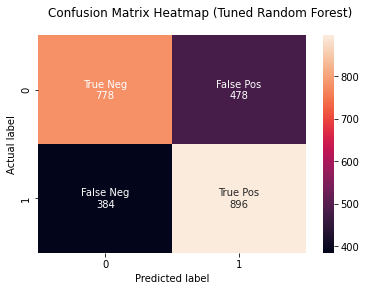

In [163]:
cm = confusion_matrix(y_test,tuned_rf_preds)
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)

test_accuracy = (cm[0][0] + cm[1][1]) / (cm[0][0] + cm[1][1] + cm[0][1] + cm[1][0])
precision = cm[1][1] / (cm[1][1]+cm[0][1])
recall = cm[1][1] / (cm[1][1]+cm[1][0])

f_measure = (2 * precision * recall) / (precision + recall)

final_string = "Model's test accuracy is {}%\n the precision is {}% \n the recall is {}% \n the f-score is {}%"\
.format(round(100*test_accuracy,2), round(100*precision,2), round(100*recall,2), round(100*f_measure,2))
print(final_string)
sns.heatmap(cm, annot=labels,fmt='')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.suptitle("Confusion Matrix Heatmap (Tuned Random Forest)")
plt.show()

### Model 4: Boosting (XGBoost)

Another decision tree classifier. We opt to use the most powerful and popular boosting model known to us, XGBoost.

#### Vanilla XGBoost

In [164]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=random_seed)
xgb_model.fit(X_train,y_train)
vanilla_xgb_preds = xgb_model.predict(X_test)
vanilla_xgb_acc = round(100*xgb_model.score(X_test,y_test),2)

Model's test accuracy is 64.51%
 the precision is 64.64% 
 the recall is 65.55% 
 the f-score is 65.09%


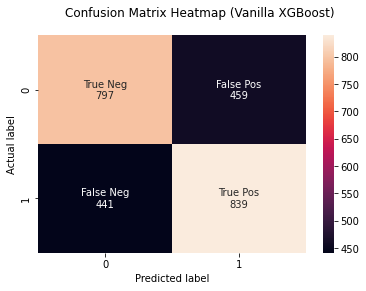

In [165]:
cm = confusion_matrix(y_test,vanilla_xgb_preds)
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)

test_accuracy = (cm[0][0] + cm[1][1]) / (cm[0][0] + cm[1][1] + cm[0][1] + cm[1][0])
precision = cm[1][1] / (cm[1][1]+cm[0][1])
recall = cm[1][1] / (cm[1][1]+cm[1][0])

f_measure = (2 * precision * recall) / (precision + recall)

final_string = "Model's test accuracy is {}%\n the precision is {}% \n the recall is {}% \n the f-score is {}%"\
.format(round(100*test_accuracy,2), round(100*precision,2), round(100*recall,2), round(100*f_measure,2))
print(final_string)
sns.heatmap(cm, annot=labels,fmt='')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.suptitle("Confusion Matrix Heatmap (Vanilla XGBoost)")
plt.show()

##### Tuned XGBoost

In [166]:
# # Build XGBoost Model

# Best hyperparameters:  {'subsample': 0.5, 'max_depth': 9, 'gamma': 10, 'eta': 0.001, 'colsample_bytree': 1}
# Best score: 65.26%

param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'eta': [0.1, 0.01, 0.001],
    'n_estimators': [25, 50, 75, 100],
    'gamma': [0, 0.1, 0.01],
    'subsample': [0.5, 0.8, 1],
    'colsample_bytree': [0.5, 0.8, 1]
}

# Initialize Model + Define the search method
if DO_SEARCH:
    xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=random_seed)
    xgb_search = RandomizedSearchCV(param_distributions = param_grid, n_iter = 50, cv = 5, scoring = 'accuracy', random_state = random_seed)
    # Fit the search to the data
    xgb_search.fit(X_train, y_train)

In [167]:
# Best Model so far:
subsample = 0.5
n_estimators = 300
max_depth = 3
reg_param = 0.05
eta = 0.01
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=random_seed,
                                max_depth = max_depth, n_estimators = n_estimators, subsample = subsample,
                                eta = eta, alpha = reg_param, reg_lambda = 1 - reg_param)
xgb_model.fit(X_train, y_train)
tuned_xgb_preds = xgb_model.predict(X_test)
tuned_xgb_acc = round(xgb_model.score(X_test,y_test) * 100,2)

Model's test accuracy is 67.19%
 the precision is 67.0% 
 the recall is 68.98% 
 the f-score is 67.98%


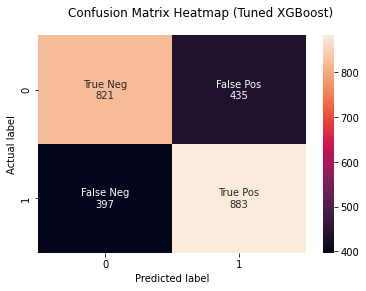

In [168]:
cm = confusion_matrix(y_test,tuned_xgb_preds)
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)

test_accuracy = (cm[0][0] + cm[1][1]) / (cm[0][0] + cm[1][1] + cm[0][1] + cm[1][0])
precision = cm[1][1] / (cm[1][1]+cm[0][1])
recall = cm[1][1] / (cm[1][1]+cm[1][0])

f_measure = (2 * precision * recall) / (precision + recall)

final_string = "Model's test accuracy is {}%\n the precision is {}% \n the recall is {}% \n the f-score is {}%"\
.format(round(100*test_accuracy,2), round(100*precision,2), round(100*recall,2), round(100*f_measure,2))
print(final_string)
sns.heatmap(cm, annot=labels,fmt='')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.suptitle("Confusion Matrix Heatmap (Tuned XGBoost)")
plt.show()

### Model 5: Support Vector Classifier

For our last model (for the time being) I explored a Support Vector Classifier, a Supervised Learning Method that is effective in high dimensional spaces, provides kernels to identify the optimal decision function and given that our output is binary, we should expect fairly good accuracy results

#### Linear Kernel (Vanilla)

In [184]:
svc = SVC(C=1, kernel='linear', random_state=random_seed)
svc.fit(X_train, y_train)
vanilla_svc_preds = svc.predict(X_test)
vanilla_svc_lin_acc = round(100*svc.score(X_test,y_test),2)

Model's test accuracy is 66.25%
 the precision is 66.18% 
 the recall is 67.73% 
 the f-score is 66.95%


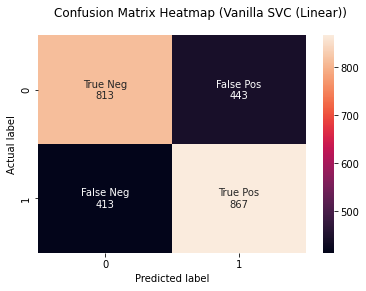

In [170]:
cm = confusion_matrix(y_test,vanilla_svc_preds)
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)

test_accuracy = (cm[0][0] + cm[1][1]) / (cm[0][0] + cm[1][1] + cm[0][1] + cm[1][0])
precision = cm[1][1] / (cm[1][1]+cm[0][1])
recall = cm[1][1] / (cm[1][1]+cm[1][0])

f_measure = (2 * precision * recall) / (precision + recall)

final_string = "Model's test accuracy is {}%\n the precision is {}% \n the recall is {}% \n the f-score is {}%"\
.format(round(100*test_accuracy,2), round(100*precision,2), round(100*recall,2), round(100*f_measure,2))
print(final_string)
sns.heatmap(cm, annot=labels,fmt='')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.suptitle("Confusion Matrix Heatmap (Vanilla SVC (Linear))")
plt.show()

#### Linear Kernel (Tuned)

In [171]:
c_values = [0.001, 0.01, 0.1, 1, 2.5,5,10,20]
tuned_svc_preds = None
tuned_svc_acc = 0

if DO_SEARCH:
    for coef in c_values:
        print(coef)
        svc = SVC(C=coef, kernel='linear', random_state=random_seed)
        svc.fit(X_train, y_train)
        if svc.score(X_test,y_test) > tuned_svc_acc:
            tuned_svc_preds = svc.predict(X_test)
            tuned_svc_acc = round(100*svc.score(X_test,y_test),2)

In [178]:
svc = SVC(C=1, kernel='linear', random_state=random_seed)
svc.fit(X_train, y_train)
tuned_svc_preds = svc.predict(X_test)
tuned_svc_acc = round(100*svc.score(X_test,y_test),2)

Note: For now C = 1 appears to be best parameter
Model's test accuracy is 66.25%
 the precision is 66.18% 
 the recall is 67.73% 
 the f-score is 66.95%


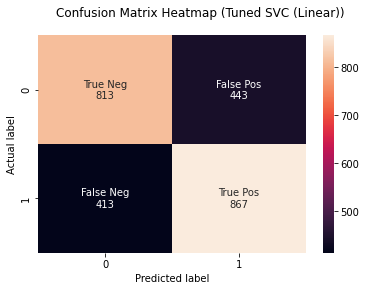

In [180]:
cm = confusion_matrix(y_test,tuned_svc_preds)
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)

test_accuracy = (cm[0][0] + cm[1][1]) / (cm[0][0] + cm[1][1] + cm[0][1] + cm[1][0])
precision = cm[1][1] / (cm[1][1]+cm[0][1])
recall = cm[1][1] / (cm[1][1]+cm[1][0])

f_measure = (2 * precision * recall) / (precision + recall)
print("Note: For now C = 1 appears to be best parameter")
final_string = "Model's test accuracy is {}%\n the precision is {}% \n the recall is {}% \n the f-score is {}%"\
.format(round(100*test_accuracy,2), round(100*precision,2), round(100*recall,2), round(100*f_measure,2))
print(final_string)
sns.heatmap(cm, annot=labels,fmt='')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.suptitle("Confusion Matrix Heatmap (Tuned SVC (Linear))")
plt.show()

#### Radial Kernal

In [185]:
svc = SVC(C=1, kernel='rbf', random_state=random_seed)
svc.fit(X_train, y_train)
vanilla_svc_rbf_acc = round(100*svc.score(X_test,y_test),2)

#### Poly Kernel

In [182]:
svc = SVC(C=1, kernel='poly', random_state=random_seed)
svc.fit(X_train, y_train)
round(100*svc.score(X_test,y_test),2)

63.05

Note: Radial & Poly Kernel SVCs do not perform as well as linear kernel. And for the time being, the vanilla SVC with a linear kernel has the best parameters, but this will be checked with further tuning. It should be noted that the default kernel of SVC is rbf, which was fairly low at 63.09 percent

### Model Results

In [186]:
accuracies = [vanila_log_reg_acc, tuned_log_reg_acc, pca_log_reg_acc,
              vanilla_rf_acc, tuned_rf_acc, vanilla_xgb_acc, tuned_xgb_acc,
              vanilla_svc_lin_acc, vanilla_svc_rbf_acc]
accuracy_names = ["Logistic Regression Accuracy (Vanilla)", "Logistic Regression Accuracy (Tuned)",
                  "Logistic Regression Accuracy (PCA)", "Random Forest Accuracy (Vanilla)", "Random Forest Accuracy (Tuned)",
                  "XGBoost Accuracy (Vanilla)", "XGBoost Accuracy (Tuned)", "Linear SVC Accuracy (Best Performing)", 'Radial SVC Accuracy (Vanilla)']
table_df = pd.DataFrame([accuracy_names,accuracies])
table_df.index = ['Model','Accuracy']
table_df = table_df.transpose().sort_values(by='Accuracy',ascending=False)
(
    GT(table_df)
    .tab_header(title="NBA Model Classification Model Accuracies",
                subtitle = f'Aggregated Features taken from Last {window_size} Games')
    .tab_stub(rowname_col="Model")
    .fmt_number(columns=['Accuracy'], compact=True)
    .tab_source_note(
        source_note=("Note: Tuned models are still undergoing hyperparameter tuning")
    )
    .tab_stubhead(label="Model")
)


GT(_tbl_data=                                    Model Accuracy
6                XGBoost Accuracy (Tuned)    67.19
7   Linear SVC Accuracy (Best Performing)    66.25
4          Random Forest Accuracy (Tuned)    66.01
2      Logistic Regression Accuracy (PCA)    65.42
1    Logistic Regression Accuracy (Tuned)    65.14
5              XGBoost Accuracy (Vanilla)    64.51
0  Logistic Regression Accuracy (Vanilla)     64.0
3        Random Forest Accuracy (Vanilla)    63.92
8           Radial SVC Accuracy (Vanilla)    63.09, _body=<great_tables._gt_data.Body object at 0x00000203C4232A40>, _boxhead=Boxhead([ColInfo(var='Model', type=<ColInfoTypeEnum.stub: 2>, column_label='Model', column_align='left', column_width=None), ColInfo(var='Accuracy', type=<ColInfoTypeEnum.default: 1>, column_label='Accuracy', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x00000203C42B8850>, _spanners=Spanners([]), _heading=Heading(title='NBA Model Classification Model Accuracies', subtitle='Aggregated Features taken from Last 15 Games', preheader=None), _stubhead='Model', _source_notes=['Note: Tuned models are still undergoing hyperparameter tuning'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x00000203C42B8C70>, _formats=[<great_tables._gt_data.FormatInfo object at 0x00000203C3FF7A60>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_bottom_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_bottom_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_bottom_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_left_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_left_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_left_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'),

### General Observations

In the end, using a dataset that aggregated statistics over a team's previous 15 games, our tuned XGBoost Model had the best performance, at 67.2% test accuracy, with the interesting caveat that it had a rather poor testing accuracy without any tuning. The models followed a stable trend of improving with hyperparameter tuning (adding regularization as needed, toying with the maximum depth and number of trees for Decision Tree Models, etc.) with the exception of the SVC classifier.

In terms of things to focus on, every single model had a better recall when it came to predicting winners (1) than for predicting the loser of a game (0). The data imbalance between 1s and 0s was not too large to explain why this was consistently the case. Therefore, we know by definition that recall is the proportion of true positives in the set of samples that are actually positive (meaning true positives and false negatives), whereas precision is the proportion of correctly identified positives from the set of samples that were identified as positive by our model. Here, positive corresponds to 1 (Team 1 winning the game), so a true positive is where we predict Team 1 wins the game and that turns out to be the case.  There is typically a tradeoff between precision and recall, and right now our model does a better job at identifying wins than at avoiding cases of incorrectly predicting a win. I will look into ways to alter my models in order to see if prioritizing precision leads to better results.

In short, I have developed a unique approach to building a model that can predict the winner of an NBA game which has real-world utility and an easy enough way to start predicting the outcomes of games for the upcoming 2024-25 season. Of course my work is nowhere close to done as I continue to find approaches and emethods to improve the accuracy of my models. 

### Next Steps

* Continue exploring current research/literature to improve model selection, feature selection and engineering, etc. In particular, incorporate player data/roster data for the particular game, information relating to trades and injuries, etc. 
* Incorporate a similar model for the postseason/playoff simulator
* Start building neural nets/deep learning networks, along with other models like Gaussian Naive Bayes
* Continue tinkering with hyperparameter tuning (slight issue here as GridSearch and RandomSearch tend to be rather time-consuming)
* Begin converting this code into a class that users can easily run on their own end by calling methods, instead of just having to run the cells in this notebook

### Helpful Resources

* ACM Paper that provides in-depth analysis of most powerful models, best features (4 Factors), and so on (2023) [here](https://dl.acm.org/doi/fullHtml/10.1145/3635638.3635646)
* Medium article with accuracy around 70% (uses neural network) [here](https://medium.com/data-sports/netty-my-personal-nba-game-winner-predictor-63cc728025c5)`
* Honors Thesis building upon previous models (contains literature review and determines best stats to explore) [here](https://digitalcommons.bryant.edu/cgi/viewcontent.cgi?article=1000&context=honors_data_science)
* Summary that outlines concerns like data imbalance, and not accounting for trades and injuries [here](https://www2.kenyon.edu/Depts/Math/hartlaub/Stat306%20Spring%202024/Executive%20Summary%20-%20Faiz%20andd%20Rafey.pdf)